# Automatic Speech Recognition with Transformer

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2021/01/13<br>
**Last modified:** 2021/01/13<br>
**Description:** Training a sequence-to-sequence Transformer for automatic speech recognition.

## Introduction

Automatic speech recognition (ASR) consists of transcribing audio speech segments into text.
ASR can be treated as a sequence-to-sequence problem, where the
audio can be represented as a sequence of feature vectors
and the text as a sequence of characters, words, or subword tokens.

For this demonstration, we will use the LJSpeech dataset from the
[LibriVox](https://librivox.org/) project. It consists of short
audio clips of a single speaker reading passages from 7 non-fiction books.
Our model will be similar to the original Transformer (both encoder and decoder)
as proposed in the paper, "Attention is All You Need".


**References:**

- [Attention is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- [Very Deep Self-Attention Networks for End-to-End Speech Recognition](https://arxiv.org/abs/1904.13377)
- [Speech Transformers](https://ieeexplore.ieee.org/document/8462506)
- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)

In [1]:
import re
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from glob import glob
import tensorflow as tf
import keras
from keras import layers

pattern_wav_name = re.compile(r'([^/\\\.]+)')

## Define the Transformer Input Layer

When processing past target tokens for the decoder, we compute the sum of
position embeddings and token embeddings.

When processing audio features, we apply convolutional layers to downsample
them (via convolution strides) and process local relationships.

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# 토큰 임베딩
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)
        self.maxlen = maxlen

    def call(self, x):
        seq_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.pos_emb(positions)
        # 브로드캐스팅을 위해 배치 차원 확장
        positions = tf.expand_dims(positions, axis=0)
        return self.emb(x) + positions


# 음성 특성 임베딩
class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, dropout_rate=0.3):
        super().__init__()
        self.conv1 = layers.Conv1D(num_hid, 11, strides=2, padding="same", activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(num_hid, 11, strides=2, padding="same", activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv1D(num_hid, 11, strides=2, padding="same", activation="relu")
        self.bn3 = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(num_hid)  # Residual 연결용 차원 보정

    def call(self, x, training=False):
        residual = self.proj(x)
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.dropout(x, training=training)
        return x + residual  # Residual 연결


## Transformer Encoder Layer

In [3]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=rate
        )
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="gelu"),  # ReLU 대신 GELU
                layers.Dropout(rate),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, mask=None, training=False):
        # Multi-Head Attention
        attn_output = self.att(inputs, inputs, attention_mask=mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed Forward
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Transformer Decoder Layer

In [4]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        # Attention blocks
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate
        )
        self.enc_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate
        )

        # Dropouts
        self.self_dropout = layers.Dropout(dropout_rate)
        self.enc_dropout = layers.Dropout(dropout_rate)
        self.ffn_dropout = layers.Dropout(dropout_rate)

        # Feed Forward Network with GELU
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="gelu"),
                layers.Dropout(dropout_rate),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        mask = i >= j - n_src + n_dest
        mask = tf.cast(mask, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat([[batch_size], tf.constant([1, 1], dtype=tf.int32)], 0)
        return tf.tile(mask, mult)

    def call(self, enc_out, target, enc_mask=None, training=False):
        batch_size = tf.shape(target)[0]
        seq_len = tf.shape(target)[1]

        # Self-Attention with causal mask
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(
            target, target, attention_mask=causal_mask, training=training
        )
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training=training))

        # Encoder-Decoder Attention
        enc_att_out = self.enc_att(
            target_norm, enc_out, attention_mask=enc_mask, training=training
        )
        enc_out_norm = self.layernorm2(target_norm + self.enc_dropout(enc_att_out, training=training))

        # Feed Forward Network
        ffn_out = self.ffn(enc_out_norm, training=training)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training=training))

        return ffn_out_norm


## Complete the Transformer model

Our model takes audio spectrograms as inputs and predicts a sequence of characters.
During training, we give the decoder the target character sequence shifted to the left
as input. During inference, the decoder uses its own past predictions to predict the
next token.

In [21]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
        label_smoothing=0.1
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes
        self.label_smoothing = label_smoothing

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, dropout_rate=0.2)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.dropout = layers.Dropout(0.3)
        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source, target = inputs
        x = self.encoder(source)
        y = self.decode(x, target)
        y = self.dropout(y)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def compute_custom_loss(self, labels, preds, mask):
        one_hot = tf.one_hot(labels, depth=self.num_classes)
        if self.label_smoothing > 0:
            one_hot = one_hot * (1 - self.label_smoothing) + self.label_smoothing / self.num_classes
        loss = tf.keras.losses.categorical_crossentropy(
            one_hot, preds, from_logits=True
        )
        mask = tf.cast(mask, dtype=loss.dtype)
        loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
        return loss

    def train_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input, dec_target = target[:, :-1], target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            mask = tf.math.not_equal(dec_target, 0)
            loss = self.compute_custom_loss(dec_target, preds, mask)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input, dec_target = target[:, :-1], target[:, 1:]
        preds = self([source, dec_input])
        mask = tf.math.not_equal(dec_target, 0)
        loss = self.compute_custom_loss(dec_target, preds, mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, start_token_idx, end_token_idx=None):
        """🔥 Greedy decoding"""
        enc_out = self.encoder(source)
        bs = tf.shape(source)[0]
        dec_input = tf.fill([bs, 1], start_token_idx)

        for _ in range(self.target_maxlen - 1):
            dec_out = self.decode(enc_out, dec_input)
            logits = self.classifier(dec_out)[:, -1:, :]  # 마지막 step
            next_token = tf.argmax(logits, axis=-1, output_type=tf.int32)
            dec_input = tf.concat([dec_input, next_token], axis=1)

            if end_token_idx is not None:
                if tf.reduce_all(tf.equal(next_token, end_token_idx)):
                    break

        return dec_input

    def generate_beam(self, source, start_token, beam_size=3):
        """🔥 단일 배치용 Beam Search"""
        enc_out = self.encoder(source)
        sequences = [[start_token]]
        scores = [0.0]

        for _ in range(self.target_maxlen - 1):
            all_candidates = []
            for i, seq in enumerate(sequences):
                dec_input = tf.expand_dims(seq, axis=0)
                dec_out = self.decode(enc_out, dec_input)
                logits = self.classifier(dec_out)[:, -1, :]
                probs = tf.nn.log_softmax(logits, axis=-1).numpy().flatten()

                top_ids = probs.argsort()[-beam_size:][::-1]
                for idx in top_ids:
                    candidate = seq + [int(idx)]
                    score = scores[i] + probs[idx]
                    all_candidates.append((candidate, score))

            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences, scores = zip(*ordered[:beam_size])

        return sequences[0]


## Download the dataset

Note: This requires ~3.6 GB of disk space and
takes ~5 minutes for the extraction of files.

In [8]:
import os
from glob import glob
import keras

# 데이터 다운로드 및 압축 해제
path_to_zip = keras.utils.get_file(
    fname="LJSpeech-1.1.tar.bz2",
    origin="https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2",
    extract=True,
    archive_format="tar",
    cache_dir="."   # 현재 작업폴더 밑에 .keras/datasets 에 저장됨
)

# 실제 데이터 경로 (keras가 자동으로 datasets/LJSpeech-1.1 에 풀어줌)
data_dir = os.path.join(os.path.dirname(path_to_zip), "datasets", "LJSpeech-1.1")
print("데이터 경로:", data_dir)

# wav 파일 경로 불러오기
wavs = glob(os.path.join(data_dir, "wavs", "*.wav"))
print("wav 개수:", len(wavs))

# metadata.csv 읽어서 id와 텍스트 매핑
id_to_text = {}
with open(os.path.join(data_dir, "metadata.csv"), encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("|")
        wav_id = parts[0]  # 예: LJ001-0001
        text = parts[2]
        id_to_text[wav_id] = text

# 데이터 매핑 함수
def get_data(wavs, id_to_text, maxlen=50):
    data = []
    for w in wavs:
        wav_id = os.path.splitext(os.path.basename(w))[0]  # 파일명에서 ID 추출
        if wav_id in id_to_text and len(id_to_text[wav_id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[wav_id]})
    return data

# 실행 예시
data = get_data(wavs, id_to_text)
print("샘플 개수:", len(data))
print(data[0])


KeyboardInterrupt: 

In [12]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 -O LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2 -C ./datasets


--2025-09-28 14:50:49--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 84.17.38.250, 2400:52e0:1500::1179:1
Connecting to data.keithito.com (data.keithito.com)|84.17.38.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  95.6MB/s    in 17s     

2025-09-28 14:51:06 (155 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [22]:
import os
from glob import glob

# 압축 해제된 데이터 경로
data_dir = "./datasets/LJSpeech-1.1"
print("데이터 경로:", data_dir)

# wav 파일 경로 불러오기
wavs = glob(os.path.join(data_dir, "wavs", "*.wav"))
print("wav 개수:", len(wavs))

# metadata.csv 읽어서 id와 텍스트 매핑
id_to_text = {}
with open(os.path.join(data_dir, "metadata.csv"), encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("|")
        wav_id = parts[0]  # 예: LJ001-0001
        text = parts[2]
        id_to_text[wav_id] = text

# 데이터 매핑 함수
def get_data(wavs, id_to_text, maxlen=50):
    data = []
    for w in wavs:
        wav_id = os.path.splitext(os.path.basename(w))[0]  # 파일명에서 ID 추출
        if wav_id in id_to_text and len(id_to_text[wav_id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[wav_id]})
    return data

# 실행 예시
data = get_data(wavs, id_to_text)
print("샘플 개수:", len(data))
print(data[0])


데이터 경로: ./datasets/LJSpeech-1.1
wav 개수: 13100
샘플 개수: 1147
{'audio': './datasets/LJSpeech-1.1/wavs/LJ025-0077.wav', 'text': 'Their food is provided for them,'}


테스트 오디오: ./datasets/LJSpeech-1.1/wavs/LJ009-0293.wav
텍스트: While Calcraft was in office other aspirants to fame appeared in the field.


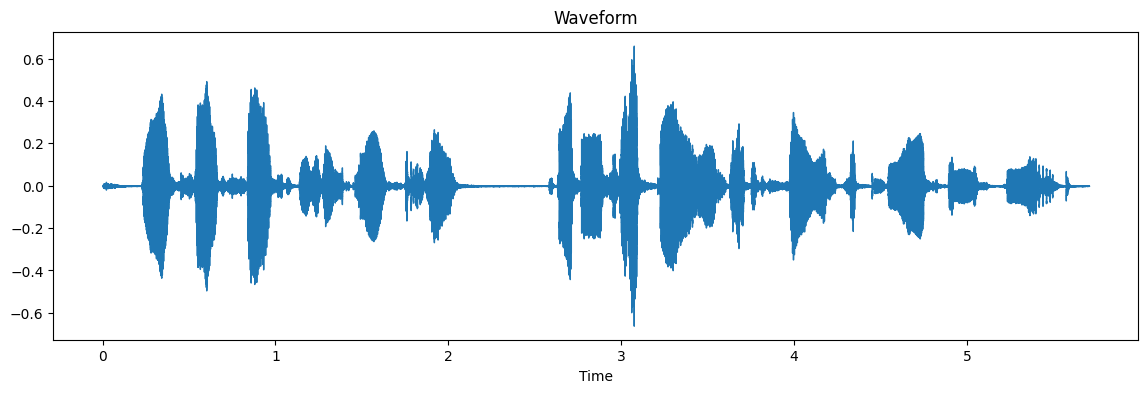

In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# 테스트용 샘플 하나 선택
sample_wav = wavs[0]
print("테스트 오디오:", sample_wav)
print("텍스트:", id_to_text[os.path.splitext(os.path.basename(sample_wav))[0]])

# librosa로 로드 (sr=None이면 원본 샘플링 레이트 유지)
y, sr = librosa.load(sample_wav, sr=None)

# 파형 시각화
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

# 실제 오디오 재생 (Colab/Jupyter에서 동작)
Audio(y, rate=sr)


## Preprocess the dataset

In [24]:

class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


max_target_len = 200  # all transcripts in out data are < 200 characters
data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]
    # padding to 10 seconds
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(path_to_audio, num_parallel_calls=tf.data.AUTOTUNE)
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


split = int(len(data) * 0.99)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)

vocab size 34


## Callbacks to display predictions

In [25]:

class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


## Learning rate schedule

In [26]:

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """linear warm up - linear decay"""
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / self.decay_epochs,
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        epoch = tf.cast(epoch, "float32")
        return self.calculate_lr(epoch)


## Create & train the end-to-end model

In [27]:
import keras
from keras import layers

# ================================
# Speech Feature Embedding (residual 제거 버전)
# ================================
class SpeechFeatureEmbedding(keras.layers.Layer):
    def __init__(self, num_hid=200, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv1D(num_hid, 11, strides=2, padding="same", activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(num_hid, 11, strides=2, padding="same", activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv1D(num_hid, 11, strides=2, padding="same", activation="relu")
        self.bn3 = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.dropout(x, training=training)
        return x

# ================================
# Transformer 정의 (기존 구현 사용)
# ================================
# Transformer, CustomSchedule, DisplayOutputs 등은 그대로 두고 이어서 사용

# ================================
# 학습 준비
# ================================
batch = next(iter(val_ds))
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=34,
)

loss_fn = keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)

optimizer = keras.optimizers.Adam(learning_rate)

model.compile(optimizer=optimizer, loss=loss_fn)

# ================================
# 학습 실행
# ================================
history = model.fit(
    ds,
    validation_data=val_ds,
    callbacks=[display_cb],
    epochs=30
)


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 3.6542

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (4, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


target:     <both ran to the sidewalk on the east side of patton at a point about a half a block south of tenth.>
prediction: <the the the te s athe t t we athe an e the the s are s se ine the o ane the the an o e olo s te the or t the s ther t anthe athe as as t o we the the onthe t aste t ast are iond d aha thees ton pt ai

target:     <toward any official of the united states.>
prediction: <the the the te s athe t t we athe an e the the s are s se ine the o ane the the an o e olo s te the or t the s ther t anthe athe as as t o we the the onthe t aste t astoore iond d aha thees ton pre i

target:     <out of these and the many other factors which may have molded the character of lee harvey oswald>
prediction: <the the the te s athe t t we athe an e the the s are s se ine the o ane the the an o e olo s te the or t the s ther t anthe athe as as t o we the the onthe t aste t ast are iond d aha thees ton pt ai

target:     <it was about twentytwo fifty b.c., when the great hammurabi made

In practice, you should train for around 100 epochs or more.

Some of the predicted text at or around epoch 35 may look as follows:
```
target:     <as they sat in the car, frazier asked oswald where his lunch was>
prediction: <as they sat in the car frazier his lunch ware mis lunch was>

target:     <under the entry for may one, nineteen sixty,>
prediction: <under the introus for may monee, nin the sixty,>
```